# Popy

## Hintergrund
- Jedes ABM beinhaltet eine gewisse Form von Interaktionsraum (Netzwerk).
- Interaktionsräume in ABMs basieren meist entweder auf generischen Mustern (Grid) und einfachen Netzwerkmodellen, in denen die Agenten zufällige Positionen einnehmen
- Eine Implementierung von Interaktionsräumen, in denen Agenten nicht zufällig, sondern aufgrund von bestimmten individuellen Attributen miteinander interagieren, ist in der Regel schwierig umzusetzen
- Die gezielte Implementierung von Interaktionen/Ties zwischen bestimmten Agenten mit bestimmten individuellen Attributen kann jedoch wichtig sein, wenn man z.B. realistischere Interaktionsräume nachbilden möchte

## Ziele
- Popy ermöglicht die einfache & flexible Implementierung von Interaktionsräumen in ABM, in denen sich Agenten aufgrund bestimmter Attribute begegnen, mithilfe einer einheitlichen Syntax
- Popy vereinfacht die Erstellung von Agenten auf Basis von Survey-Daten und somit die empirische Fundierung der Agenten-Attribute
- großes und übergeordnetes Ziel: realistischere und empirischere Populationen in ABMs

## Statische Netzwerke

### Agenten erstellen

In Popy werden Agenten und ihre Attribute typischerweise auf Basis eines `pandas.DataFrame` erstellt.
Im Folgenden erstellen wir daher per Hand einen kleinen DataFrame, welchen wir zu Beginn für die Erstellung der Agenten nutzen.

In [1]:
import pandas

data = {
    "age": [10, 24, 2, 80, 70, 36, 83, 12, 32, 12],
    "gender": ["m", "m", "m", "w", "w", "m", "m", "m", "w", "w"],
    "favorite_food": ["cheese", "pizza", "pizza", "cheese", "pizza", "pizza", "pizza", "cheese", "cheese", "pizza"],
    "time_at_restaurant": [0.5, 1, 1, 2, 0.5, 2, 2, 1, 2, 4],
}

df = pandas.DataFrame(data)

df

,age,gender,favorite_food,time_at_restaurant
0,10,m,cheese,0.5
1,24,m,pizza,1.0
2,2,m,pizza,1.0
3,80,w,cheese,2.0
4,70,w,pizza,0.5
5,36,m,pizza,2.0
6,83,m,pizza,2.0
7,12,m,cheese,1.0
8,32,w,cheese,2.0
9,12,w,pizza,4.0


Wir starten nun mit der Definition unserer Agenten als Klasse.
Wir definieren unsere Klasse `Agent` als Kind-Klasse der durch Popy bereit gestellten Klasse `popy.Agent`.
Zudem fügen wir dem Agenten für dieses Beispiel das Instanz-Attribut `self.happiness` mit dem Wert `10` hinzu, welches aber zunächst nicht weiter verwendet wird.

In [2]:
import popy

class Agent(popy.Agent):
    def __init__(self, model, *args, **kwargs):
        super().__init__(model, *args, **kwargs)
        self.happiness = 10

Nun beginnen wir mit der Erstellung unserer ersten Population.
Für diese Aufgabe stellt **Popy** den sogenannten `PopMaker` zur Verfügung.
Unten wird dieser importiert und eine Instanz erstellt.
Wie du siehst, erwartet der `PopMaker` ebenfalls ein `Model`-Objekt als Argument.

In [3]:
from popy.pop_maker import PopMaker

pop_maker = PopMaker()

agents = pop_maker.create_agents(agent_class=Agent, df=df)

agents

AgentList (10 objects)

Wir sehen, dass `pop_maker` eine sogenannte `AgentList` erstellt hat.
Dies ist eine spezielle Form der Liste, welche die erstellten Agenten enthält.

Schauen wir uns mal beispielhaft den ersten Agenten der Liste an:

In [4]:
type(agents[0])

__main__.Agent

In [5]:
vars(agents[0])

{'_var_ignore': [],
 'id': 1,
 'type': 'Agent',
 'log': {},
 'model': Model,
 'p': {},
 'happiness': 10,
 'age': 10,
 'gender': 'm',
 'favorite_food': 'cheese',
 'time_at_restaurant': 0.5}

Wir sehen, dass der Agent neben einer Reihe weiterer Attribute das Attribute `happiness` sowie die Attribute, welche im DataFrame definiert wurden, enthält.

### Erste Location erstellen

Bisher stehen die Agenten noch unverbunden nebeneinander, da noch kein Interaktionsraum definiert wurde.
Popy ermöglicht es nun, Verbindungen zwischen spezifischen Agenten auf Basis ihrer jeweiligen Attribute zu erstellen.
Dazu muss man in Popy sogenannte *Locations* definieren.
Dies sind bestimmte Objekt-Typen, die über die Spezifikation bestimmter Attribute und Methoden, Verbindungen zwischen bestimmten Agenten herstellen.
Während der Definition der Locations dienen diese sozusagen als Interface bzw. als Syntax zur Spezifikation des Interaktionsraumes.
Auf Ebene der Simulation kannst du dir die Locations wirklich als *Orte* vorstellen, an denen sich Agenten treffen und miteinander interagieren können.

Unten definieren wir unseren ersten Ort: eine Pizzeria.
Bei der Definition der Ort-Klasse muss diese von der durch Popy bereit gestellten Ort-Basis-Klasse erben.

In [6]:
class Pizzeria(popy.Location):
    pass

Für unsere Pizzeria bestimmen wir erstmal keine weiteren Eigenschaften und übernehmen dadurch alle Grundkonfigurationen der Elternklasse `popy.Location`.
Nachdem der Ort definiert wurde, können wir diesen erstellen.
Hierfür bietet der `PopMaker` die Methode `create_locations()`.
Diese Methode erstellt die unter dem Parameter `location_classes` angegebenen Locations in Abhängigkeit zu der unter dem Parameter `agents` angegebenen Population von Agenten.
Was der letzte Punkt genau heißt, werden wir später sehen.
Wichtig ist hier noch zu erwähnen, dass die Locations nicht nur erstellt werden, sondern die Agenten auch den entsprechenden Locations zugewiesen werden.

In [7]:
locations = pop_maker.create_locations(agents=agents, location_classes=[Pizzeria])

Wie wir unten in der `LocationList` namens `locations` sehen können, haben wir eine Location des Typs `Pizzeria` erstellt.

In [8]:
locations

LocationList (1 object)

In [9]:
locations[0]

Pizzeria (Obj 12)

Da wir keine genaueren Spezifikationen der Pizzeria vorgenommen haben, wurden dieser alle Agenten zugewiesen.
Das heißt, dass alle 10 Agenten diese eine Pizzeria besuchen.
Das lässt sich nachvollziehen, indem wir uns das Attribut `Location.agents` der Pizzeria anschauen:

In [10]:
locations[0].agents

AgentList (10 objects)

Im Hintergrund hat sich jedoch auch etwas in Bezug auf die Agenten verändert.
Alle Agenten, die denselben Ort besuchen, stehen in Verbindung zueinander - in Worten der Netzwerkanalyse besteht also ein Edge zwischen diesen.
Dies können wir auf der Agenten-Ebene nachvollziehen, indem wir die Methode `Agent.neighbors()` ausführen.
Unten rufen wir diese Methode für den ersten Agenten auf.
Wir bekommen eine `AgentList` mit 9 Objekten zurück.
Dies bedeutet, dass der entsprechende Agent mit den 9 anderen Agenten in Verbindung steht.
Dies macht Sinn, denn alle 10 Agenten wurden der einen existierenden Pizzeria zugeordnet.

In [11]:
agents[0].neighbors()

AgentList (9 objects)

Eine Möglichkeit, einen Überblick über die erstellten Orte und die entstandenen Verknüpfungen zu bekommen, ist die Methode `PopMaker.eval_affiliations()`.
Diese zeigt, wie viele Agenten (durchschnittlich) pro Location-Typ zugordnet wurden und wie viele Locations (durchschnittlich) einem Agenten zugeordnet wurden.

In [12]:
pop_maker.eval_affiliations()



______________________________________
Number of agents per location
______________________________________

               n_agents                                        
                  count  mean std   min   25%   50%   75%   max
location_class                                                 
Pizzeria            1.0  10.0 NaN  10.0  10.0  10.0  10.0  10.0


______________________________________
Number of affiliated locations per agent
______________________________________

count    10.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: n_affiliated_locations, dtype: float64


In [13]:
import popy.utils as utils
from bokehgraph import BokehGraph
import networkx as nx

graph = utils.create_agent_graph(agents)

plot = BokehGraph(graph)
plot.draw()

KeyError: '_var_ignore'

Einen noch plastischeren Eindruck über die entstandenen Verbindungen gewinnt man, wenn man sich die Verknüpfungen der Agenten als Netzwerk anschaut:

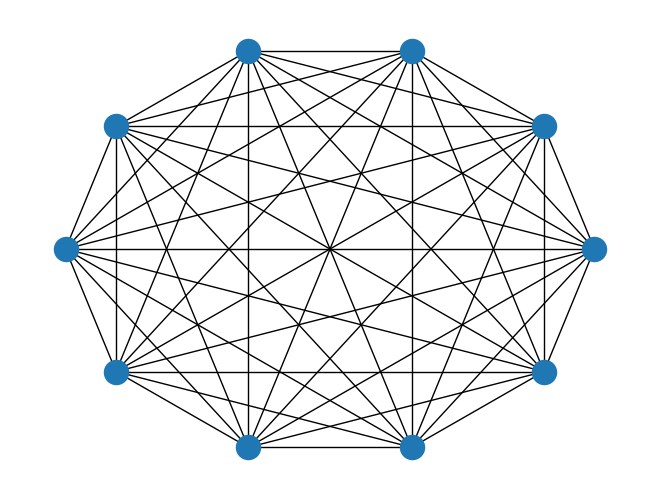

In [ ]:
import popy.utils as utils
nx.draw_kamada_kawai(utils.create_agent_graph(agents))

Da alle Agenten eine einzige Pizzeria besuchen, treffen alle Agenten aufeinander und ein vollverbundenes Netzwerk entsteht.

Eine weitere Möglichkeit das Netzwerk zu evaluieren ist das Erstellen einer Kontaktmatrix:

,1,2,3,4,5,6,7,8,9,10
10,1,1,1,1,1,1,1,1,1,0
9,1,1,1,1,1,1,1,1,0,1
8,1,1,1,1,1,1,1,0,1,1
7,1,1,1,1,1,1,0,1,1,1
6,1,1,1,1,1,0,1,1,1,1
5,1,1,1,1,0,1,1,1,1,1
4,1,1,1,0,1,1,1,1,1,1
3,1,1,0,1,1,1,1,1,1,1
2,1,0,1,1,1,1,1,1,1,1
1,0,1,1,1,1,1,1,1,1,1


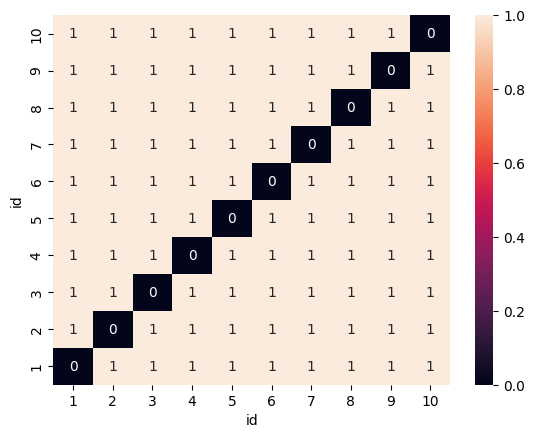

In [ ]:
utils.create_contact_matrix(agents=agents, plot=True)

Diese kann nicht nur auf der Ebene der einzelnen Agenten erstellt werden, sondern auch auf der Ebene bestimmter Gruppenmerkmale:

,cheese,pizza
pizza,24,30
cheese,12,24


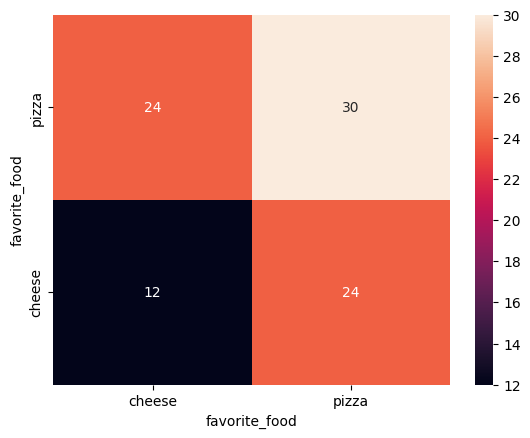

In [ ]:
utils.create_contact_matrix(agents=agents, plot=True, attr="favorite_food")

### Location-Zugang einschränken

Nun wollen wir die Eigenschaften der Pizzeria etwas ausweiten.
Mithilfe der Methode `Location.join()` bestimmen wir, dass nur Agenten, deren Lieblingsessen Pizza ist, die Pizzeria besuchen.

In [ ]:
class Pizzeria(popy.Location):
    def join(self, agent):
        return agent.favorite_food == "pizza"

In [ ]:
agents = pop_maker.create_agents(agent_class=Agent, df=df)
locations = pop_maker.create_locations(agents=agents, location_classes=[Pizzeria])

Nun sieht das entstehende Netzwerk so aus, da sich nur die 6 Agenten, deren Lieblingsessen Pizza ist, in der Pizzeria treffen:

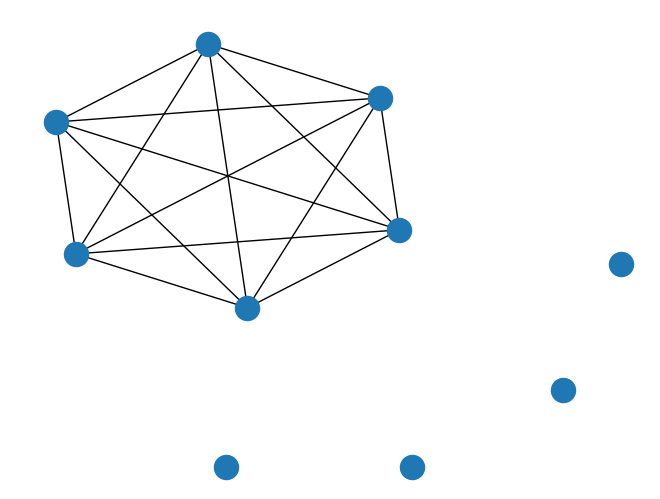

In [ ]:
nx.draw_kamada_kawai(utils.create_agent_graph(agents))

,cheese,pizza
pizza,0,30
cheese,0,0


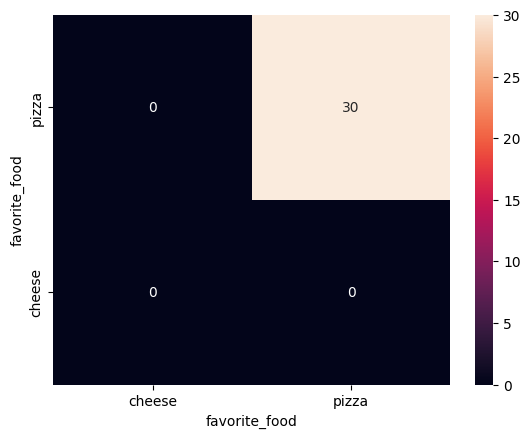

In [ ]:
utils.create_contact_matrix(agents=agents, plot=True, attr="favorite_food")

### Location-Größe einstellen

Innerhalb der Methode `Location.setup()` können verschiedene Eigenschaften einer Location bestimmt werden, wie z.B. die Größe `self.size` d.h. die Anzahl der nodes pro Location.
Der `PopMaker` liest diese Werte aus und erstellt dann die benötigte Anzahl der entsprechenden Location.

In [ ]:
class Pizzeria(popy.Location):
    def setup(self):
        self.size = 3
        
    def join(self, agent):
        return agent.favorite_food == "pizza"

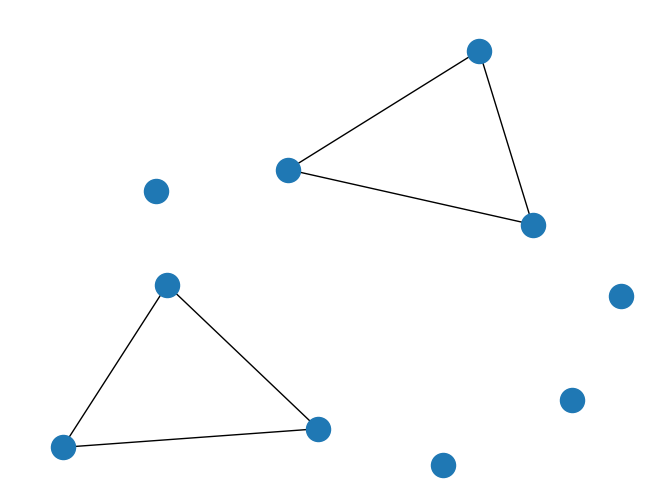

In [ ]:
agents = pop_maker.create_agents(agent_class=Agent, df=df)
locations = pop_maker.create_locations(agents=agents, location_classes=[Pizzeria])

nx.draw_kamada_kawai(utils.create_agent_graph(agents))

In [ ]:
pop_maker.eval_affiliations()



______________________________________
Number of agents per location
______________________________________

               n_agents                                   
                  count mean  std  min  25%  50%  75%  max
location_class                                            
Pizzeria            2.0  3.0  0.0  3.0  3.0  3.0  3.0  3.0


______________________________________
Number of affiliated locations per agent
______________________________________

count    10.000000
mean      0.600000
std       0.516398
min       0.000000
25%       0.000000
50%       1.000000
75%       1.000000
max       1.000000
Name: n_affiliated_locations, dtype: float64


,cheese,pizza
pizza,0,12
cheese,0,0


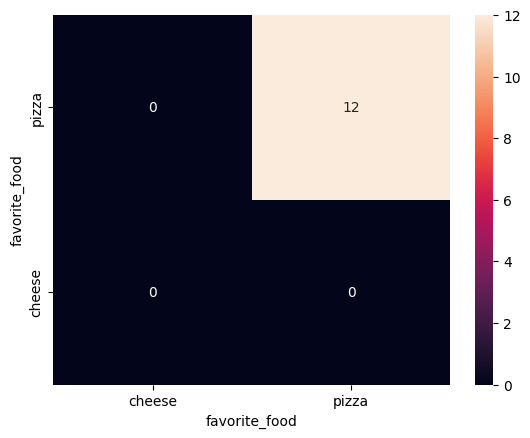

In [ ]:
utils.create_contact_matrix(agents=agents, plot=True, attr="favorite_food")

### Sub-Locations erzeugen

Die Methode `Location.group()` ermöglicht es unkompliziert Sub-Locations einer Location zu erstellen.
Für jeden Wert, der pro Agent durch `Location.group()` zurück gegeben wird, wird eine Sub-Location erstellt.
Im Beispiel unten werden geschlechtergetrennte Pizzerien erstellt:

In [ ]:
class Pizzeria(popy.Location):
    def setup(self):
        self.size = 3
        
    def join(self, agent):
        return agent.favorite_food == "pizza"
    
    def group(self, agent):
        return agent.gender

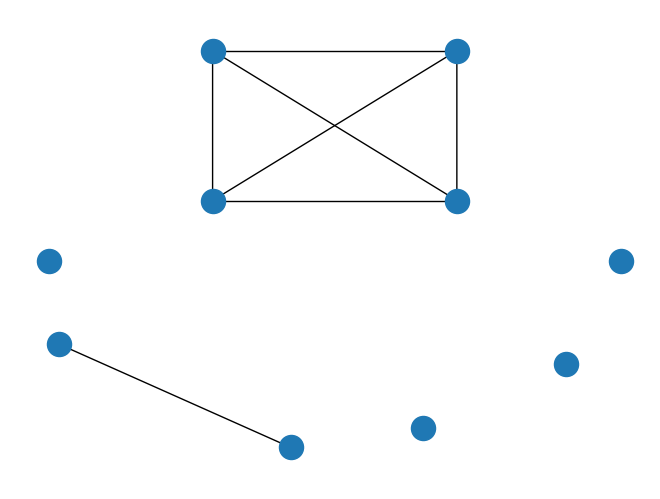

In [ ]:
agents = pop_maker.create_agents(agent_class=Agent, df=df)
locations = pop_maker.create_locations(agents=agents, location_classes=[Pizzeria])

nx.draw_kamada_kawai(utils.create_agent_graph(agents))

### Gewichtete Verbindungen

Die Methode `Location.weight()` ermöglicht es, gewichtete Verbindungen zwischen Agenten zu erzeugen.
Der Wert, der pro Agent durch die Methode `Location.weight()` zurückgegeben wird, bestimmt dabei zunächst die Stärke der Verbindung zwischen dem Agenten und der Location.
Um die Stärke der Verbindung zwischen zwei Agenten zu ermitteln, werden die Gewichte der entsprechenden Agenten über alle gemeinsamen Locations mithilfe verschiedener wählbarer Formeln kombiniert.

Unten im Beispiel wird die Stärke eines Agenten zu der von ihm besuchten Pizzeria über das Attribut `Agent.time_at_restaurant` bestimmt.

In [ ]:
class Pizzeria(popy.Location):
    def setup(self):
        self.size = 3
        
    def join(self, agent):
        return agent.favorite_food == "pizza"
    
    def group(self, agent):
        return agent.gender
    
    def weight(self, agent):
        return agent.time_at_restaurant

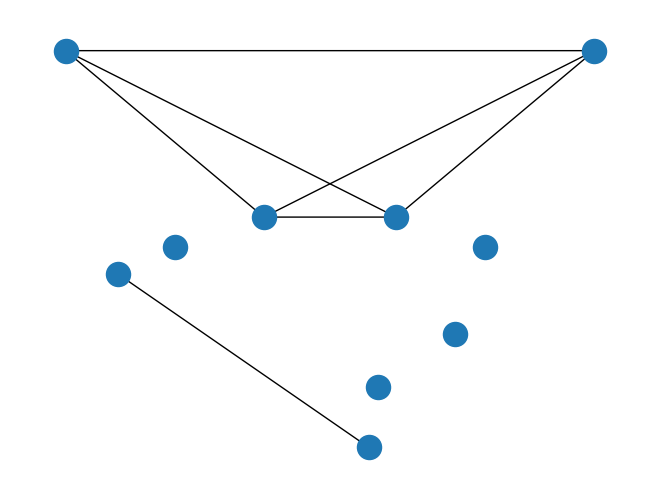

In [ ]:
agents = pop_maker.create_agents(agent_class=Agent, df=df)
locations = pop_maker.create_locations(agents=agents, location_classes=[Pizzeria])

nx.draw_kamada_kawai(utils.create_agent_graph(agents))

Um die Stärke der Verbindung zwischen zwei Agenten zu ermitteln, kann die Methode `Agent.contact_weight` verwendet werden:

In [ ]:
agent1 = agents[5]
agent2 = agents[6]

agent1.contact_weight(agent2)

4.0

Obige Methode kann praktisch sein, wenn während einer Simulation das Kontaktgewicht zwischen zwei Agenten relevant ist für die Interaktion zwischen diesen.

Desweiteren kann auch die Kontaktmatrix gewichtete Verbindungen darstellen:

,51,52,53,54,55,56,57,58,59,60
60,0,0,0,0,2,0,0,0,0,0
59,0,0,0,0,0,0,0,0,0,0
58,0,0,0,0,0,0,0,0,0,0
57,0,2,2,0,0,4,0,0,0,0
56,0,2,2,0,0,0,4,0,0,0
55,0,0,0,0,0,0,0,0,0,2
54,0,0,0,0,0,0,0,0,0,0
53,0,1,0,0,0,2,2,0,0,0
52,0,0,1,0,0,2,2,0,0,0
51,0,0,0,0,0,0,0,0,0,0


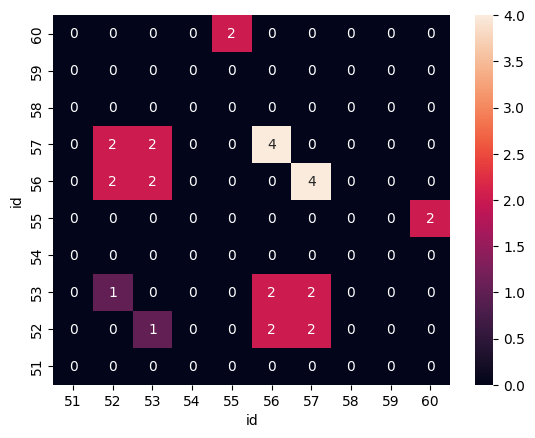

In [ ]:
utils.create_contact_matrix(agents=agents, plot=True, weighted=True)

### Mehrere Locations